# CHURN PREDICTION

Churn is the action of stop using facilities or doing business in an entity. Customer Churn means lost customer that may lead into lost revenue. Therefore, a running business should track its activity and prevent customer churn. 

Dataset: [Telco Customer Churn](https://www.kaggle.com/blastchar/telco-customer-churn)
<br>

In [3]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import math

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mutual_info_score, accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score

from imblearn.over_sampling import RandomOverSampler

### Read Dataset

In [5]:
df = pd.read_csv("dataset/WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### EDA

In [6]:
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

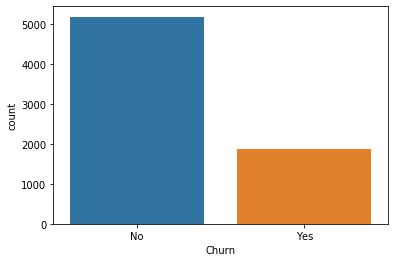

In [7]:
sns.countplot(df["Churn"])

In [8]:
df.isna().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7032 non-null float64
Churn               7043 non-null object
dtypes: float64(2), int64(2), ob

In [10]:
df["TotalCharges"] = df["TotalCharges"].fillna(0)

In [11]:
df.corr()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
SeniorCitizen,1.000000,0.016567,0.220173,0.103006
tenure,0.016567,1.000000,0.247900,0.826178
MonthlyCharges,0.220173,0.247900,1.000000,0.651174
TotalCharges,0.103006,0.826178,0.651174,1.000000


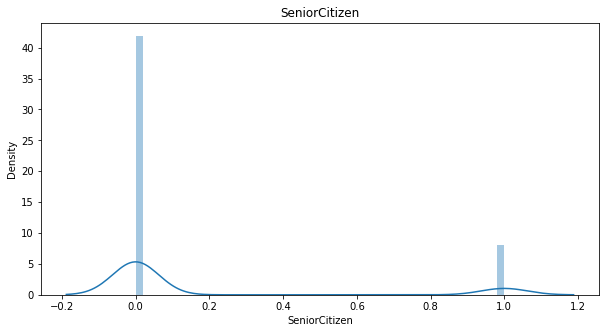

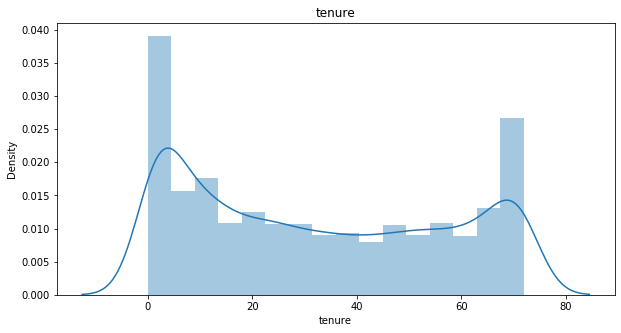

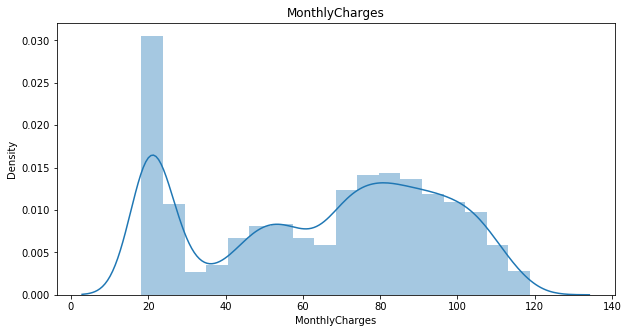

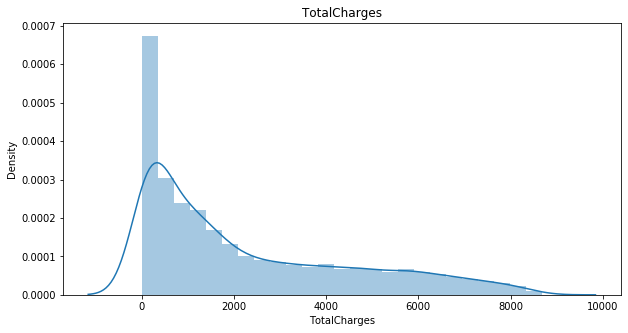

In [12]:
numerical = df.select_dtypes(include=["int64", "float64"]).columns
for col in numerical:
    plt.figure(figsize=(10,5))
    sns.distplot(df[col])
    plt.title(col)
    plt.show()

In [13]:
def mutual_info_churn_score(series):
    return round(mutual_info_score(series, df.Churn), 2)

categorical = df.drop(["customerID", "Churn"], axis=1).select_dtypes(include=["object"]).columns
df[categorical].apply(mutual_info_churn_score)

gender              0.00
Partner             0.01
Dependents          0.01
PhoneService        0.00
MultipleLines       0.00
InternetService     0.06
OnlineSecurity      0.06
OnlineBackup        0.05
DeviceProtection    0.04
TechSupport         0.06
StreamingTV         0.03
StreamingMovies     0.03
Contract            0.10
PaperlessBilling    0.02
PaymentMethod       0.04
dtype: float64

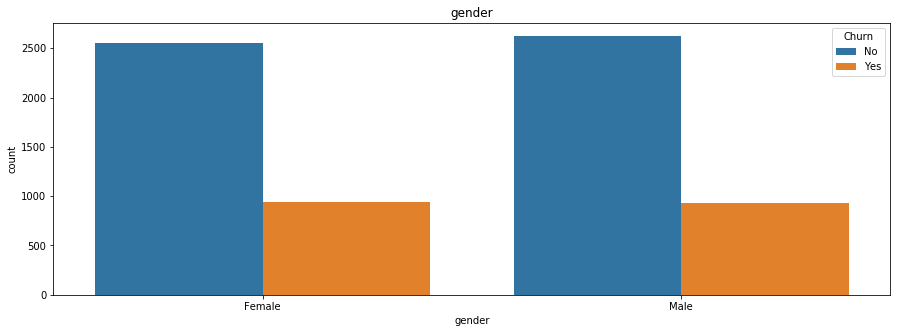

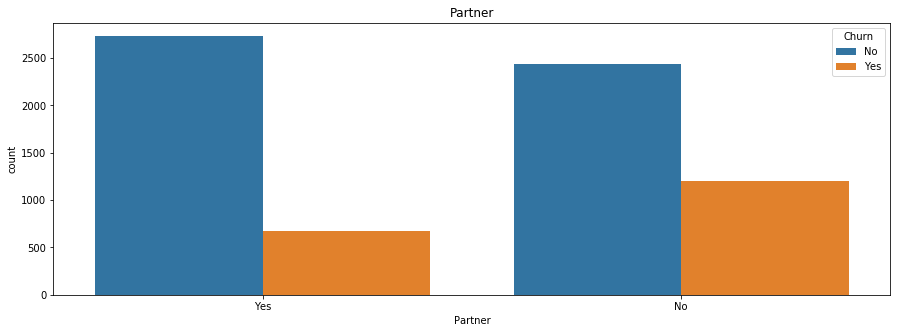

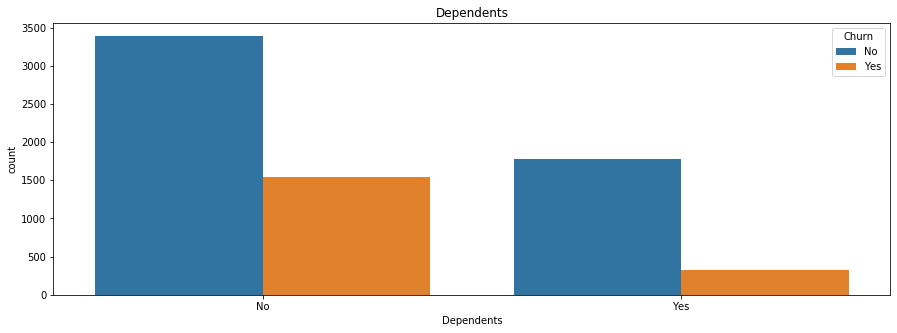

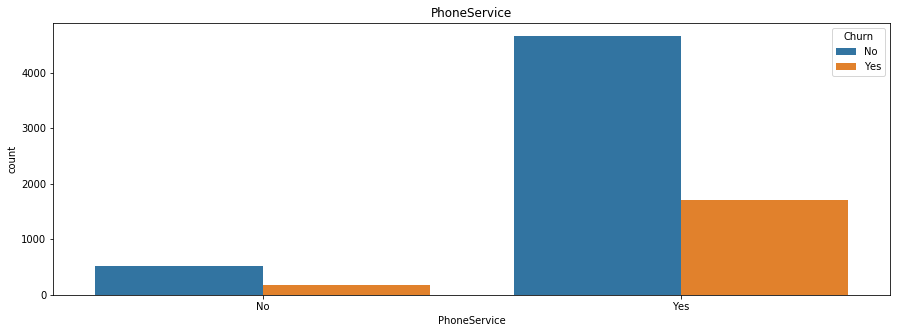

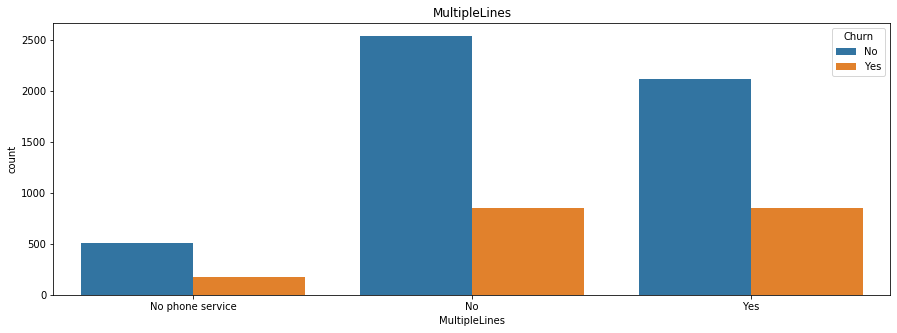

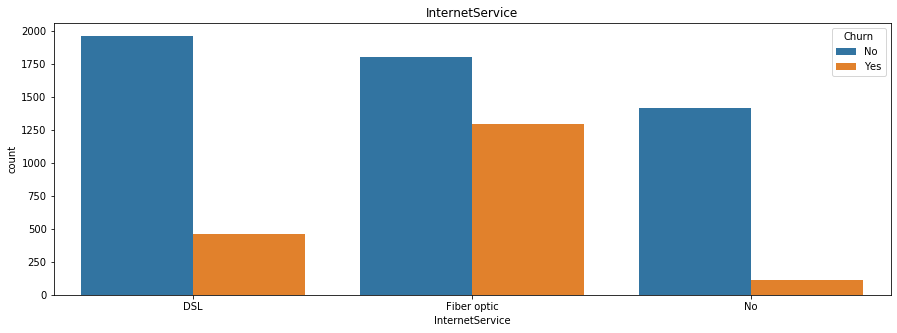

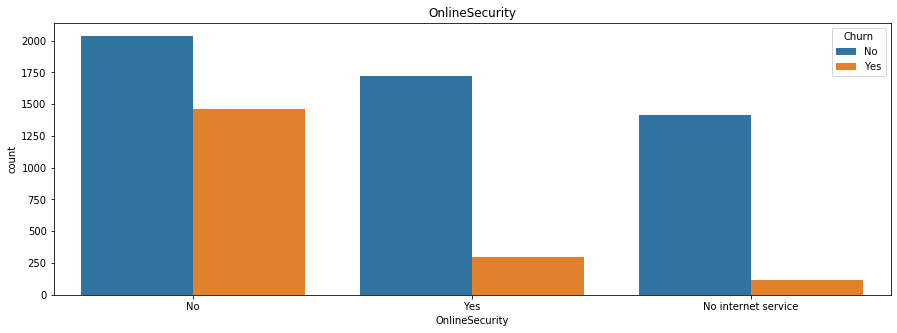

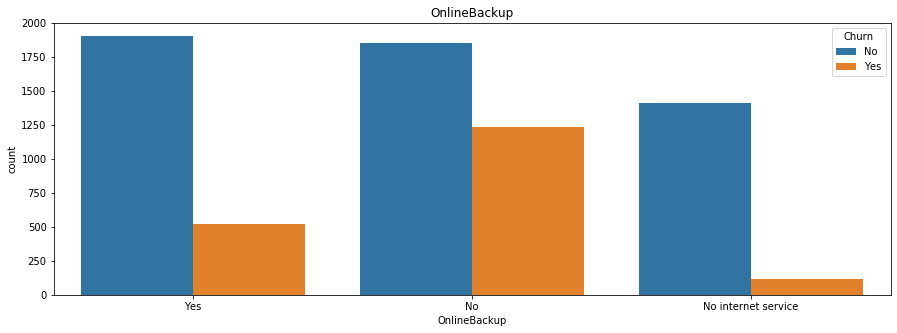

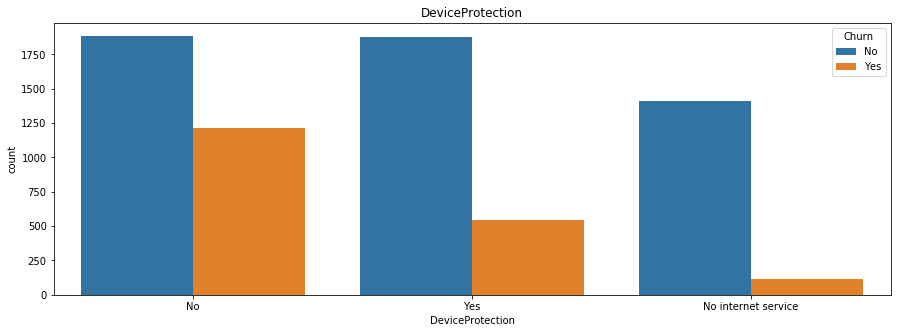

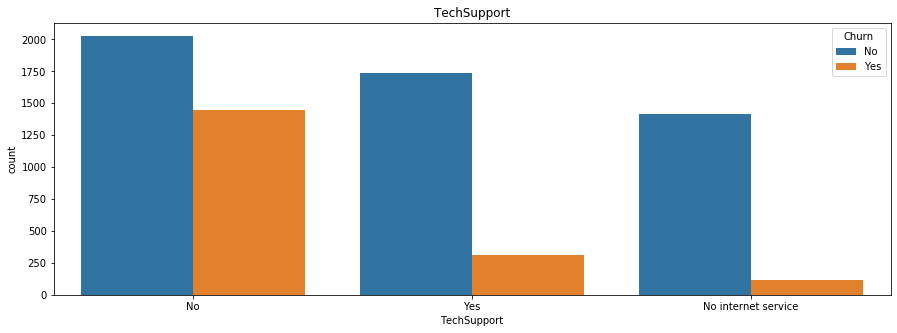

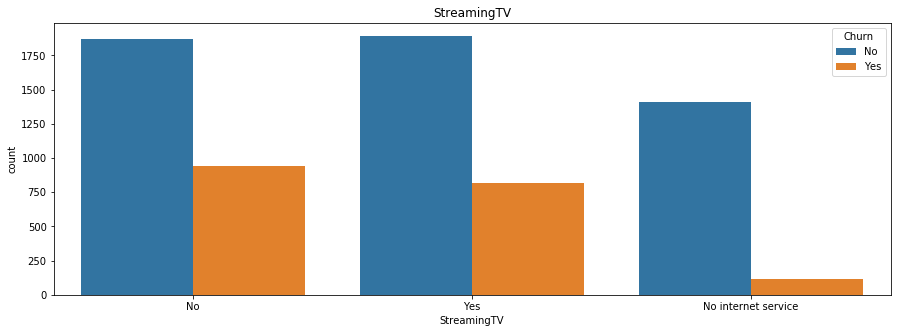

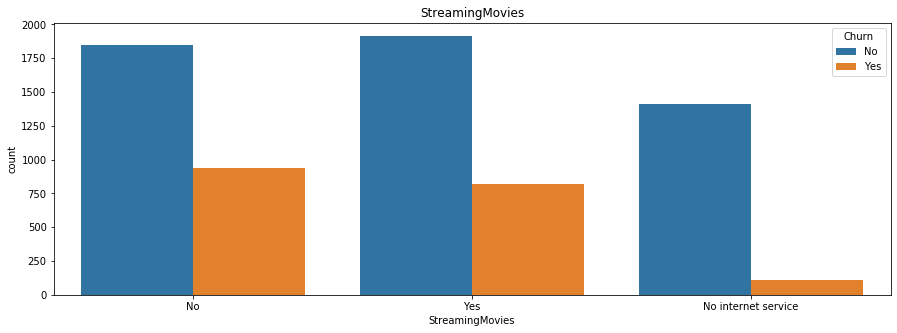

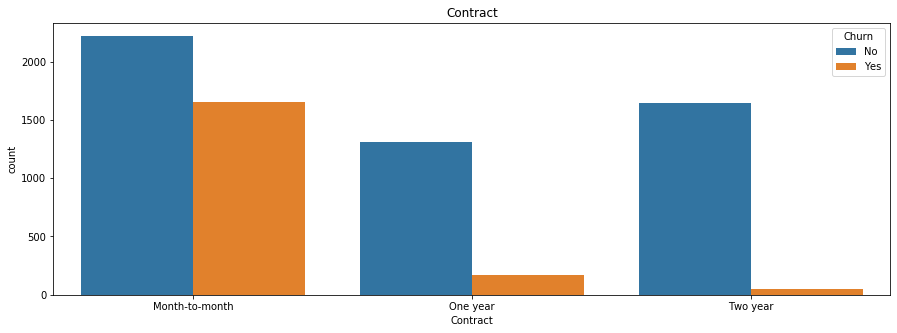

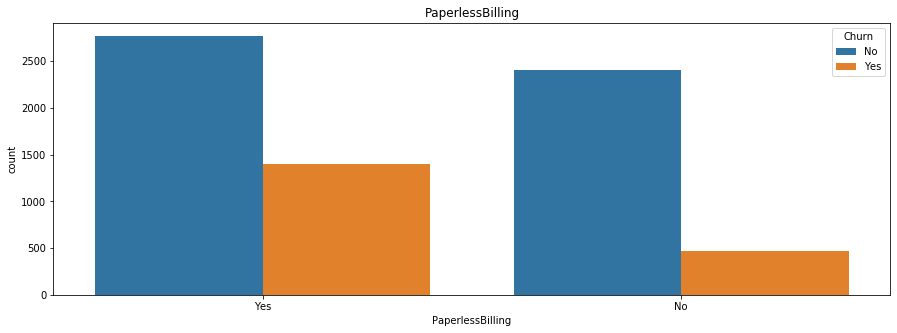

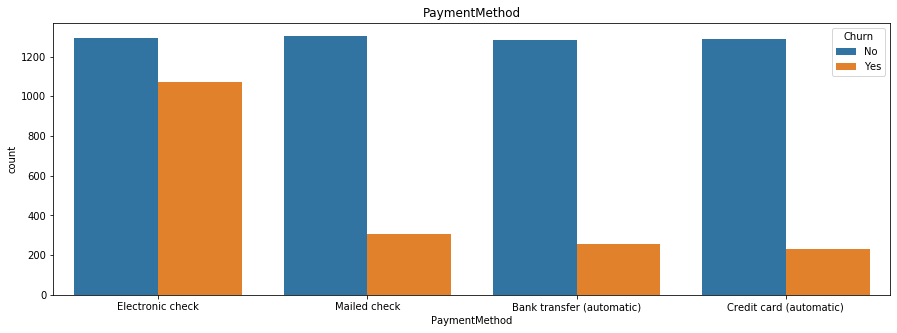

In [14]:
for col in categorical:
    plt.figure(figsize=(15,5))
    sns.countplot(df[col], hue=df["Churn"])
    plt.title(col)
    plt.show()

### Feature Engineering

In [15]:
df = pd.get_dummies(data=df, columns=categorical, prefix=categorical)
df.head()

,customerID,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,gender_Female,gender_Male,Partner_No,Partner_Yes,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,7590-VHVEG,0,1,29.85,29.85,No,1,0,0,1,...,0,1,0,0,0,1,0,0,1,0
1,5575-GNVDE,0,34,56.95,1889.50,No,0,1,1,0,...,0,0,1,0,1,0,0,0,0,1
2,3668-QPYBK,0,2,53.85,108.15,Yes,0,1,1,0,...,0,1,0,0,0,1,0,0,0,1
3,7795-CFOCW,0,45,42.30,1840.75,No,0,1,1,0,...,0,0,1,0,1,0,1,0,0,0
4,9237-HQITU,0,2,70.70,151.65,Yes,1,0,1,0,...,0,1,0,0,0,1,0,0,1,0


In [16]:
le = LabelEncoder()
df["Churn"] = le.fit_transform(df["Churn"])
df.head()

,customerID,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,gender_Female,gender_Male,Partner_No,Partner_Yes,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,7590-VHVEG,0,1,29.85,29.85,0,1,0,0,1,...,0,1,0,0,0,1,0,0,1,0
1,5575-GNVDE,0,34,56.95,1889.50,0,0,1,1,0,...,0,0,1,0,1,0,0,0,0,1
2,3668-QPYBK,0,2,53.85,108.15,1,0,1,1,0,...,0,1,0,0,0,1,0,0,0,1
3,7795-CFOCW,0,45,42.30,1840.75,0,0,1,1,0,...,0,0,1,0,1,0,1,0,0,0
4,9237-HQITU,0,2,70.70,151.65,1,1,0,1,0,...,0,1,0,0,0,1,0,0,1,0


### Modeling

In [17]:
X = df.drop(["customerID", "Churn"], axis=1)
y = df["Churn"]

X_full_train, X_test, y_full_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_full_train, y_full_train, test_size=0.2)

In [18]:
print(y_train.value_counts())

logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_val)
print(round(math.sqrt(accuracy_score(y_pred, y_val)), 3))
print(round(math.sqrt(precision_score(y_pred, y_val)), 3))
print(round(math.sqrt(recall_score(y_pred, y_val)), 3))

0    3298
1    1209
Name: Churn, dtype: int64
0.903
0.736
0.823


In [19]:
ros = RandomOverSampler(sampling_strategy="minority")
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)
print(y_train_ros.value_counts())

logreg = LogisticRegression()
logreg.fit(X_train_ros, y_train_ros)
y_pred = logreg.predict(X_val)
print(round(math.sqrt(accuracy_score(y_pred, y_val)), 3))
print(round(math.sqrt(precision_score(y_pred, y_val)), 3))
print(round(math.sqrt(recall_score(y_pred, y_val)), 3))

1    3298
0    3298
Name: Churn, dtype: int64
0.872
0.9
0.722


In [20]:
acc = accuracy_score(y_pred, y_val)
auc = roc_auc_score(y_val, y_pred)

print(acc, auc)

0.7595385980479148 0.7761401557285873
